In [2]:
import sys
from matplotlib import pyplot as plt
import numpy as np
from dataclasses import dataclass
import pandas as pd
from itertools import product, chain
from IPython.display import clear_output
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from tqdm import tqdm

In [3]:
transform = lambda img: np.array(np.asarray(img).flatten())/256
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

In [5]:
def train(network,train_loader, test_loader, epochs, loss):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step()
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            sys.stdout.write('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

class MSELoss:
    def __init__(self):
        pass

    def forward(self, X, y):
        self.X = X
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return np.mean(np.square(self.X - self.y))

    def backward(self):
        return 2 * (self.X - self.y) / self.y.shape[0]
    
@dataclass
class HyperParams:
    lr: float
    epochs: int

    def __init__(self, lr, epoch):
        self.lr = lr
        self.epochs = int(epoch)

    def as_vec(self):
        return np.array([
            self.lr, self.epochs
        ])

In [6]:
class ReLU:
    def __init__(self):
        pass
    
    def step(self):
        pass

    def forward(self, X):
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        return (self.X > 0) * dLdy

In [7]:
class Adam:
    def __init__(self, params, beta1 = 0.9, beta2 = 0.99, nu = 1., eta = 1e-8, lr=0.001):
        self.params = params
        self.beta1 = beta1
        self.beta2 = beta2
        self.nu = nu
        self.eta = eta
        self.lr = lr
        self.m = [np.zeros(p.shape) for p in self.params]
        self.v = [np.zeros(p.shape) for p in self.params]

    def step(self, gradW, gradb):
          grads = [gradW, gradb]
          for i, p in enumerate(self.params):
              self.m[i]=self.beta1*self.m[i]+(1-self.beta1)*grads[i]
              self.v[i]=self.beta2*self.v[i]+(1-self.beta2)*grads[i]**2
              m_ = self.m[i]/(1-self.beta1**(i+1))
              v_ = self.v[i]/(1-self.beta2**(i+1))
              p-=self.lr*self.nu/(np.sqrt(v_)+self.eta)*m_

class SGD:
    def __init__(self, params, lr=1e-2):
        self.params = params
        self.lr = lr

    def step(self,gradW, gradb):
        grads = [gradW, gradb]
        for i, p in enumerate(self.params):
            p -= self.lr * grads[i]

class NAG:
    def __init__(self, params, lr=1e-2, gamma=0.9):
        self.params = params
        self.lr=lr
        self.gamma=gamma
        self.momentum = [np.zeros(p.shape) for p in self.params]

    def step(self,gradW, gradb):
        grads = [gradW, gradb]
        for i, p in enumerate(self.params):
            self.momentum[i] = self.gamma * self.momentum[i] + self.lr * grads[i]
            p-=self.momentum[i]


class AdaGrad:
    def __init__(self, params, eta=1e-8, lr=1e-2):
        self.params=params
        self.eta = eta
        self.lr = lr
        self.G = [0] * len(self.params)

    def step(self,gradW, gradb):
        grads = [gradW, gradb]
        for i, p in enumerate(self.params):
            self.G[i] += grads[i] ** 2
            p -= self.lr / np.sqrt(self.G[i] + self.eta) * grads[i]

In [8]:
class Linear:
    def __init__(self, input_size, output_size, optimizer):
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)
        optimizer_class = optimizer[0]
        optimizer_options = optimizer[1] if len(optimizer) > 2 else {}
        optimizer = optimizer_class([self.W,self.b], **optimizer_options)
        self.optimizer=optimizer

    def step(self):
        self.optimizer.step(self.dLdW,self.dLdb)

    def forward(self, X):
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx


class NeuralNet:
    def __init__(self, modules):
        self.modules = modules

    def step(self):
        for i in range(len(self.modules)):
            self.modules[i].step()

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

In [9]:
class Creature:
    def __init__(self, hp: HyperParams):
        self.hp = hp
        adam=[Adam,{'lr': hp.lr}]
        self.network = NeuralNet([
            Linear(784, 100,adam), ReLU(),
            Linear(100, 100,adam), ReLU(),
            Linear(100, 10,adam)
        ])
        self.loss = MSELoss()
        self.optimizer = 'Adam'

    def __repr__(self):
        return str(self.hp)
    
    def test(self, test_loader):
        accuracies=[]
        for X, y in test_loader:
            X = X.view(X.shape[0], -1).numpy()
            y = y.numpy()
            prediction = self.network.forward(X)
            loss_batch = self.loss.forward(prediction, y)
            accuracies.append((np.argmax(prediction, 1)==y).mean())
        return np.mean(accuracies)

    def train(self, train_loader):
        for epoch in range(self.hp.epochs):
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = self.network.forward(X)
                loss_batch = self.loss.forward(prediction, y)
                dLdx = self.loss.backward()
                self.network.backward(dLdx)
                self.network.step()

    def fitnes(self, dl):
        return self.test(dl)

100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


-> generation 1 of 10


100%|██████████| 6/6 [00:03<00:00,  1.97it/s]
C:\Users\Golum\AppData\Local\Temp\ipykernel_8400\1441597685.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.cs = self.df.fitnes / self.df.fitnes.sum()


                                          creature    fitnes        cs
4                 HyperParams(lr=0.001, epochs=30)  0.781746  0.164338
1  HyperParams(lr=0.023125105549977435, epochs=15)  0.784722  0.164964
1                 HyperParams(lr=0.001, epochs=30)  0.795635  0.167258
5                   HyperParams(lr=0.1, epochs=30)  0.795635  0.167258
5                   HyperParams(lr=0.1, epochs=30)  0.798611  0.167883
3                  HyperParams(lr=0.01, epochs=30)  0.800595  0.168300
-> generation 2 of 10


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
C:\Users\Golum\AppData\Local\Temp\ipykernel_8400\1441597685.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.cs = self.df.fitnes / self.df.fitnes.sum()


                                          creature    fitnes        cs
2   HyperParams(lr=0.00985341516012143, epochs=30)  0.796627  0.165943
5                   HyperParams(lr=0.1, epochs=30)  0.798611  0.166357
3                 HyperParams(lr=0.001, epochs=30)  0.799603  0.166563
3                  HyperParams(lr=0.01, epochs=30)  0.800595  0.166770
1  HyperParams(lr=0.001579530806413992, epochs=30)  0.801587  0.166977
5    HyperParams(lr=0.0923666421832327, epochs=30)  0.803571  0.167390
-> generation 3 of 10


100%|██████████| 6/6 [00:04<00:00,  1.49it/s]
C:\Users\Golum\AppData\Local\Temp\ipykernel_8400\1441597685.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.cs = self.df.fitnes / self.df.fitnes.sum()


                                          creature    fitnes        cs
5                   HyperParams(lr=0.1, epochs=30)  0.798611  0.166116
3                 HyperParams(lr=0.001, epochs=30)  0.799603  0.166323
3                  HyperParams(lr=0.01, epochs=30)  0.800595  0.166529
1  HyperParams(lr=0.001579530806413992, epochs=30)  0.801587  0.166735
5    HyperParams(lr=0.0923666421832327, epochs=30)  0.803571  0.167148
5                   HyperParams(lr=0.1, epochs=30)  0.803571  0.167148
-> generation 4 of 10


100%|██████████| 6/6 [00:03<00:00,  1.60it/s]
C:\Users\Golum\AppData\Local\Temp\ipykernel_8400\1441597685.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.cs = self.df.fitnes / self.df.fitnes.sum()


                                          creature    fitnes        cs
5                   HyperParams(lr=0.1, epochs=30)  0.798611  0.166116
3                 HyperParams(lr=0.001, epochs=30)  0.799603  0.166323
3                  HyperParams(lr=0.01, epochs=30)  0.800595  0.166529
1  HyperParams(lr=0.001579530806413992, epochs=30)  0.801587  0.166735
5    HyperParams(lr=0.0923666421832327, epochs=30)  0.803571  0.167148
5                   HyperParams(lr=0.1, epochs=30)  0.803571  0.167148
-> generation 5 of 10


100%|██████████| 6/6 [00:04<00:00,  1.24it/s]
C:\Users\Golum\AppData\Local\Temp\ipykernel_8400\1441597685.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.cs = self.df.fitnes / self.df.fitnes.sum()


                                          creature    fitnes        cs
1                   HyperParams(lr=0.1, epochs=23)  0.799603  0.166288
3  HyperParams(lr=0.001426607833945434, epochs=30)  0.799603  0.166288
3                  HyperParams(lr=0.01, epochs=30)  0.800595  0.166495
1  HyperParams(lr=0.001579530806413992, epochs=30)  0.801587  0.166701
5    HyperParams(lr=0.0923666421832327, epochs=30)  0.803571  0.167114
5                   HyperParams(lr=0.1, epochs=30)  0.803571  0.167114
-> generation 6 of 10


100%|██████████| 6/6 [00:04<00:00,  1.25it/s]
C:\Users\Golum\AppData\Local\Temp\ipykernel_8400\1441597685.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.cs = self.df.fitnes / self.df.fitnes.sum()


                                          creature    fitnes        cs
3  HyperParams(lr=0.001426607833945434, epochs=30)  0.799603  0.166220
3                  HyperParams(lr=0.01, epochs=30)  0.800595  0.166426
1  HyperParams(lr=0.001579530806413992, epochs=30)  0.801587  0.166632
3  HyperParams(lr=0.001426607833945434, epochs=25)  0.801587  0.166632
5    HyperParams(lr=0.0923666421832327, epochs=30)  0.803571  0.167045
5                   HyperParams(lr=0.1, epochs=30)  0.803571  0.167045
-> generation 7 of 10


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]
C:\Users\Golum\AppData\Local\Temp\ipykernel_8400\1441597685.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.cs = self.df.fitnes / self.df.fitnes.sum()


                                          creature    fitnes        cs
3                  HyperParams(lr=0.01, epochs=30)  0.800595  0.166289
1  HyperParams(lr=0.001579530806413992, epochs=30)  0.801587  0.166495
3  HyperParams(lr=0.001426607833945434, epochs=25)  0.801587  0.166495
5    HyperParams(lr=0.0923666421832327, epochs=30)  0.803571  0.166907
5                   HyperParams(lr=0.1, epochs=30)  0.803571  0.166907
3  HyperParams(lr=0.001426607833945434, epochs=25)  0.803571  0.166907
-> generation 8 of 10


100%|██████████| 6/6 [00:04<00:00,  1.49it/s]
C:\Users\Golum\AppData\Local\Temp\ipykernel_8400\1441597685.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.cs = self.df.fitnes / self.df.fitnes.sum()


                                          creature    fitnes        cs
3  HyperParams(lr=0.001426607833945434, epochs=25)  0.801587  0.166358
5                   HyperParams(lr=0.1, epochs=27)  0.802579  0.166564
5    HyperParams(lr=0.0923666421832327, epochs=30)  0.803571  0.166770
5                   HyperParams(lr=0.1, epochs=30)  0.803571  0.166770
3  HyperParams(lr=0.001426607833945434, epochs=25)  0.803571  0.166770
3  HyperParams(lr=0.032044384306339255, epochs=25)  0.803571  0.166770
-> generation 9 of 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]
C:\Users\Golum\AppData\Local\Temp\ipykernel_8400\1441597685.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.cs = self.df.fitnes / self.df.fitnes.sum()


                                          creature    fitnes        cs
5                   HyperParams(lr=0.1, epochs=27)  0.802579  0.166324
5    HyperParams(lr=0.0923666421832327, epochs=30)  0.803571  0.166530
5                   HyperParams(lr=0.1, epochs=30)  0.803571  0.166530
3  HyperParams(lr=0.001426607833945434, epochs=25)  0.803571  0.166530
3  HyperParams(lr=0.032044384306339255, epochs=25)  0.803571  0.166530
2                   HyperParams(lr=0.1, epochs=30)  0.808532  0.167558
-> generation 10 of 10


100%|██████████| 6/6 [00:04<00:00,  1.32it/s]
C:\Users\Golum\AppData\Local\Temp\ipykernel_8400\1441597685.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.cs = self.df.fitnes / self.df.fitnes.sum()


                                          creature    fitnes        cs
5                   HyperParams(lr=0.1, epochs=27)  0.802579  0.166324
5    HyperParams(lr=0.0923666421832327, epochs=30)  0.803571  0.166530
5                   HyperParams(lr=0.1, epochs=30)  0.803571  0.166530
3  HyperParams(lr=0.001426607833945434, epochs=25)  0.803571  0.166530
3  HyperParams(lr=0.032044384306339255, epochs=25)  0.803571  0.166530
2                   HyperParams(lr=0.1, epochs=30)  0.808532  0.167558
                                          creature    fitnes        cs
5                   HyperParams(lr=0.1, epochs=27)  0.802579  0.166324
5    HyperParams(lr=0.0923666421832327, epochs=30)  0.803571  0.166530
5                   HyperParams(lr=0.1, epochs=30)  0.803571  0.166530
3  HyperParams(lr=0.001426607833945434, epochs=25)  0.803571  0.166530
3  HyperParams(lr=0.032044384306339255, epochs=25)  0.803571  0.166530
2                   HyperParams(lr=0.1, epochs=30)  0.808532  0.167558
(Hyper

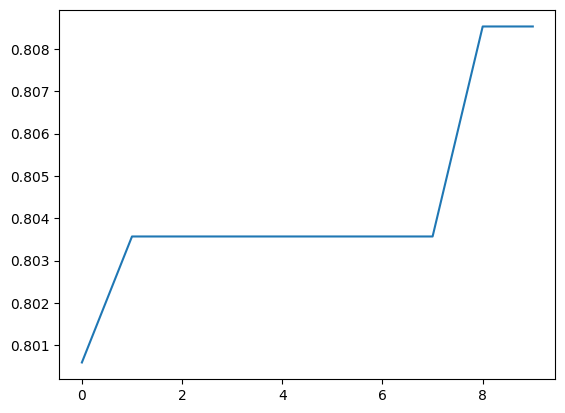

In [10]:
class GenAlgorithm:
    def __init__(self, dl_len=1000) -> None:
        self.dl = {
            'test': DataLoader(Subset(train_dataset, range(0, dl_len)), shuffle=True, batch_size=16),
            'train': DataLoader(Subset(train_dataset, range(dl_len, int(dl_len*1.2))), shuffle=True, batch_size=16),
        }
        lrs = [0.001,0.01, 0.1]
        epochs = [10, 30]
        self.creatures = []
        self.pop_size = 0
        for lr, ep_num in product(lrs, epochs):
            self.creatures.append(Creature(HyperParams(lr=lr, epoch=ep_num)))
            self.pop_size += 1

    def train(self):
        for c in tqdm(self.creatures):
            c.train(self.dl['train'])

    def build_df(self, creatures: list[Creature]):
        df = pd.DataFrame({'creature': creatures})
        df['fitnes'] = df.creature.map(lambda x: x.fitnes(self.dl['test']))
        df.fitnes = df.fitnes
        df['cs'] = df.fitnes / df.fitnes.sum()
        df['cs'] = df['cs'] / sum(df.cs)
        df = df.sort_values(by=['fitnes'], axis=0, ascending=True)
        return df

    def selection(self):
        self.creatures = list(np.random.choice(
            self.df.creature,
            size=self.pop_size,
            p=self.df.cs
        ))

    def crossing_over(self):
        def cross(p1, p2):
            pc = 0.6
            genes1, genes2 = p1.hp.as_vec(), p2.hp.as_vec()
            while True:
                try:
                    ngenes1, ngenes2 = [], []
                    for g1, g2 in zip(genes1, genes2):
                        r = np.random.random()
                        if r < pc:
                            ngenes1.append(g1)
                            ngenes2.append(g2)
                        else:
                            c = np.random.random()
                            ngenes1.append(g1*c + (1-c)*g2)
                            ngenes2.append(g2*c + (1-c)*g1)
                except AssertionError:
                    continue
                else:
                    return [Creature(HyperParams(*ngenes1)), Creature(HyperParams(*ngenes2))]

        np.random.shuffle(self.creatures)
        pairs = [tuple(self.creatures[i:i+2]) for i in range(0, 2*len(self.creatures)//2-1, 2)] + \
            [tuple(self.creatures[-2:])]
        offsprings = list(map(lambda x: cross(*x), pairs))
        self.creatures = list(chain(*offsprings))[:self.pop_size]

    def mutation(self):
        pm = 0.4
        def mutate(c):
            if np.random.random() > pm:
                return c
            gens = c.hp.as_vec()
            i = np.random.randint(0, len(gens))
            gens[i] = np.random.uniform(*[
                                            (0.001, 0.01),
                                            (10, 30),
                                        ][i])
            try:
                return Creature(HyperParams(*gens))
            except:
                return c

        self.creatures = list(map(mutate, self.creatures))

    def replace_with_new_gen(self):
        new_df = self.build_df(self.creatures)
        all_df = pd.concat([self.df, new_df], axis=0)
        all_df.fitnes
        all_df.sort_values(by='fitnes', ascending=True, inplace=True)
        self.df = all_df.tail(self.pop_size)
        self.df.cs = self.df.fitnes / self.df.fitnes.sum()
        print(self.df)

    def evolve(self, N):
        best = []
        self.train()
        self.df = self.build_df(self.creatures)

        for i in range(N):
            print(f'-> generation {i+1} of {N}')
            self.selection()
            self.crossing_over()
            self.mutation()
            self.train()
            self.replace_with_new_gen()
            best.append(self.df.iloc[-1].fitnes)

        print(self.df)
        row = self.df['fitnes'].idxmax()

        plt.plot(range(len(best)), best)
        return self.df.iloc[row].creature, self.df.iloc[row].fitnes

algorithm = GenAlgorithm()
print(algorithm.evolve(10))

Epoch 9... (Train/Test) Loss: 0.010/0.010	Accuracy: 0.958/0.958

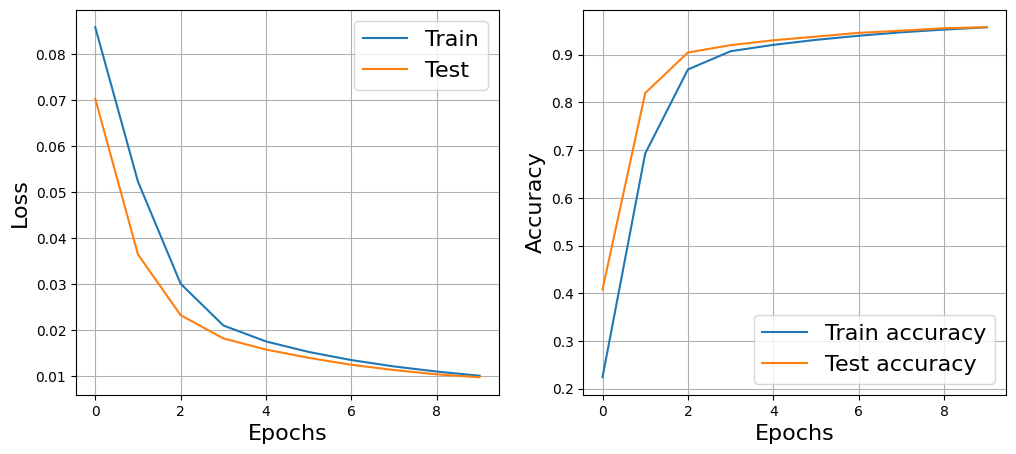

100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


In [64]:
sgd=[SGD, {'lr': 0.005}]
network = NeuralNet([
    Linear(784, 100, sgd), ReLU(),
    Linear(100, 100, sgd), ReLU(),
    Linear(100, 10, sgd)
])
loss = MSELoss()
train_mse_sgd, test_mse_sgd, train_ac_mse_sgd, test_ac_mse_sgd = train(network,train_loader,test_loader, 10, loss=loss)

Epoch 9... (Train/Test) Loss: 0.002/0.004	Accuracy: 0.992/0.978

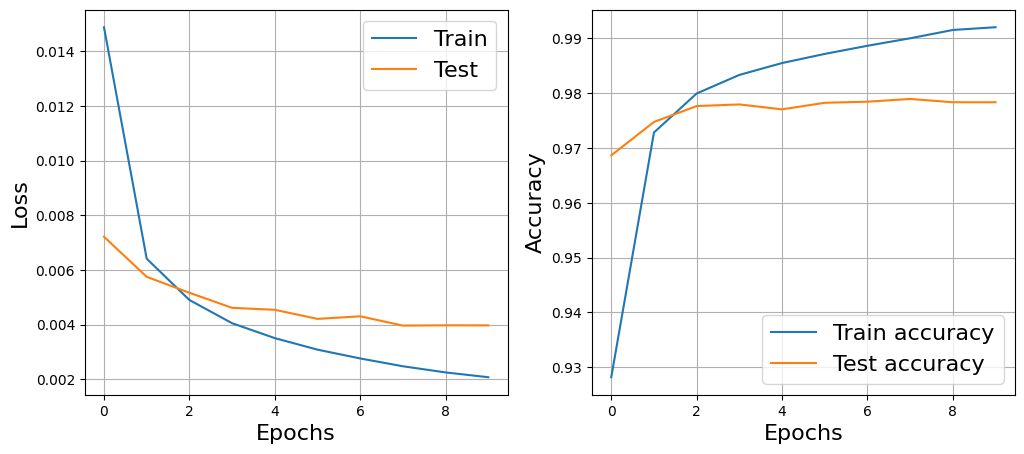

100%|██████████| 10/10 [01:05<00:00,  6.59s/it]


In [ ]:
adam=[Adam,{'lr': 0.005}]
network = NeuralNet([
    Linear(784, 100, adam), ReLU(),
    Linear(100, 100, adam), ReLU(),
    Linear(100, 10, adam)
])
loss = MSELoss()
train_mse_adam, test_mse_adam, train_ac_mse_adam, test_ac_mse_adam = train(network, train_loader, test_loader, 10, loss=loss)

Epoch 9... (Train/Test) Loss: 0.006/0.007	Accuracy: 0.976/0.970

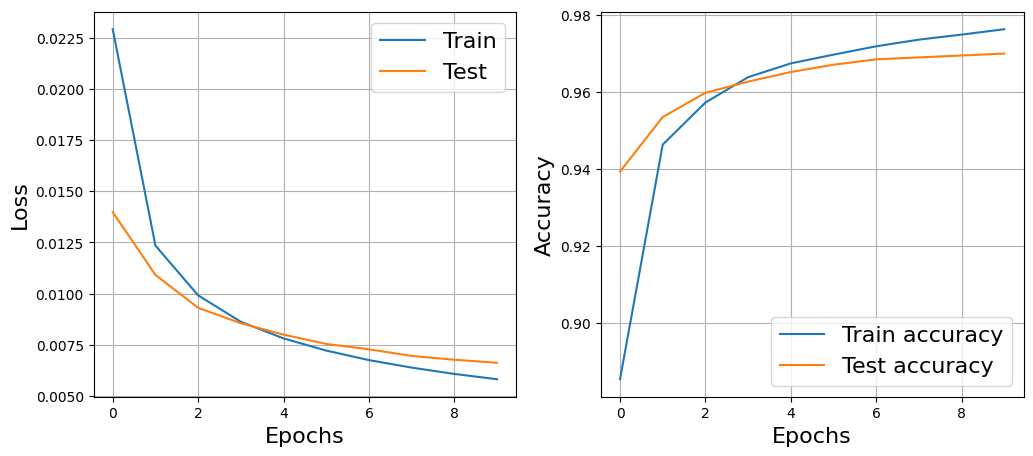

100%|██████████| 10/10 [00:59<00:00,  5.91s/it]


In [61]:
adagrad = [AdaGrad,{'lr': 0.005}]
network = NeuralNet([
    Linear(784, 100, adagrad), ReLU(),
    Linear(100, 100, adagrad), ReLU(),
    Linear(100, 10, adagrad)
])
loss = MSELoss()
train_mse_adg, test_mse_adg, train_ac_mse_adg, test_ac_mse_adg = train(network, train_loader, test_loader, 10, loss=loss)

Epoch 9... (Train/Test) Loss: 0.003/0.004	Accuracy: 0.990/0.981

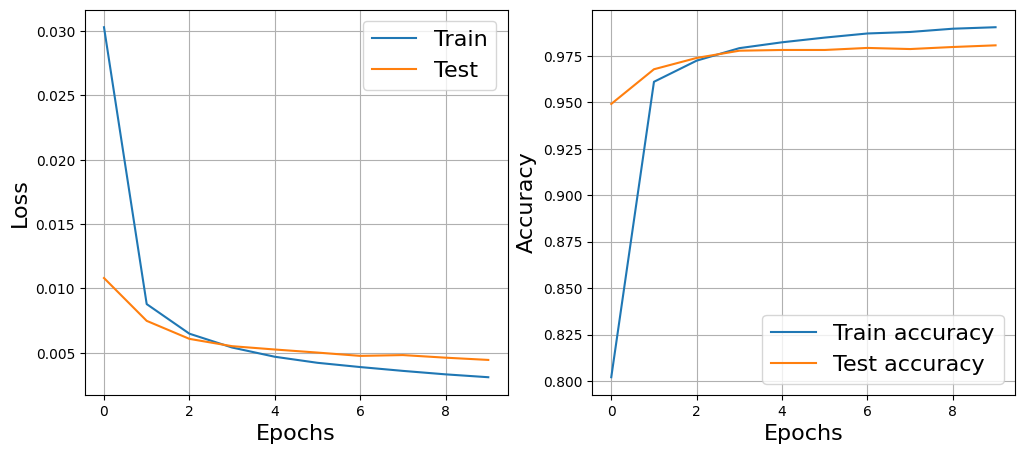

100%|██████████| 10/10 [00:53<00:00,  5.30s/it]


In [62]:
nag = [NAG,{'lr': 0.005}]
network = NeuralNet([
    Linear(784, 100, nag), ReLU(),
    Linear(100, 100, nag), ReLU(),
    Linear(100, 10, nag)
])
loss = MSELoss()
train_mse_nag, test_mse_nag, train_ac_mse_nag, test_ac_mse_nag = train(network, train_loader, test_loader, 10, loss=loss)

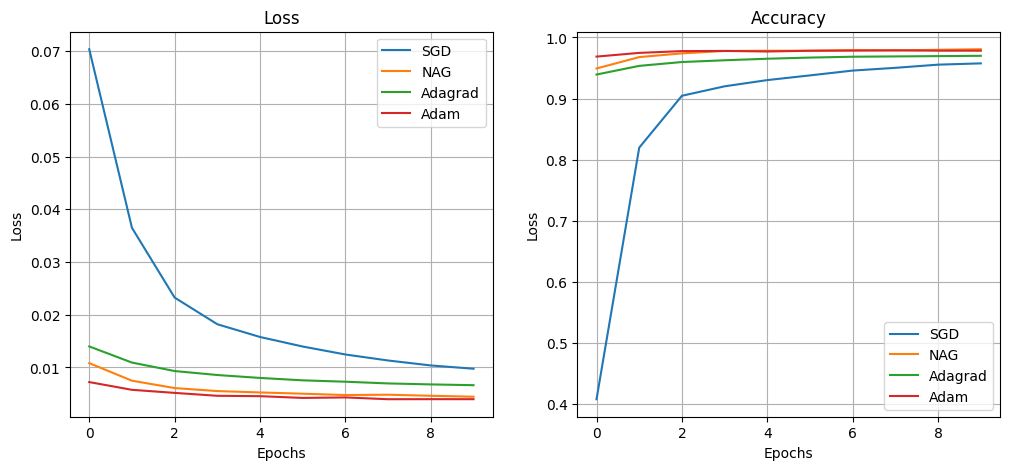

In [66]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(test_mse_sgd, label='SGD')
plt.plot(test_mse_nag, label='NAG')
plt.plot(test_mse_adg, label='Adagrad')
plt.plot(test_mse_adam, label='Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(test_ac_mse_sgd, label='SGD')
plt.plot(test_ac_mse_nag, label='NAG')
plt.plot(test_ac_mse_adg, label='Adagrad')
plt.plot(test_ac_mse_adam, label='Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.grid()
plt.show()